# <center><u>Mutational signatures in breast cancer</u></center>

### Table of Contents

- [Introduction](#Introduction)
- [Material and methods](#MM)
- [Results](#Results)
    - [Tumors selection](#rpEXWG)
    - [Whole exome sequenced tumors characterization](#rpSP)
    - [Similarity null distribution](#rpBP)
    - [Tumors clustering](#rpDH)
    - [Mutational signatures stability](#rpBC)
- [Discussion and conclusion](#DC)

<a id='Introduction'></a>

## Introduction

Mutations accumulate during cell life, mainly caused by DNA damages or replication errors. And some of these mutations will be capable to drive the tumor development. We know that mutations are caused by mutational processes like smoking or exposure to UV light. These processes leave patterns of mutations that can be isolated by mutational signatures. The degree by which a signature is present in a tumor represents therefore the activity of the associated mutational process in that tumor. This information is crucial for patient care.<br>
<a href="https://www.flickr.com/photos/10610528@N04/3864631473/sizes/o/in/set-72157605562537449/"><img src="mutacc.jpg" alt="Mutations accumulation"></a><br>
<a href="https://www.nature.com/articles/nature12477">[ref]</a> ALEXANDROV & all. 22/08/2013. "Signatures of Mutational Processes in Human Cancer" in Nature 500, 415-421.

All point mutations are first organized in 96 classes with 5’ and 3’ nucleotides.
<a href="https://en.wikipedia.org/wiki/Mutational_signatures#/media/File:MutationTypes_v3.jpg"><img src="96class.PNG" alt="Mutation classes"> <img src="mutsame.PNG" alt="Same mutations"> </a>

The Mutations Catalogue matrix is next computed after analysing all point mutations from all tumors present in the DNA sequencing data. Non-negative matrix factorization is performed to isolate the weights associated to given mutational signatures. The Kullback-Leibler divergence distance is used since we assume that the Mutations Catalogue comes from a mixture of independent Poisson distributions. Each value in the Mutations Catalogue representing therefore a specific expected number of occurrences (lambda).<br>
<a href="https://bioconductor.org/packages/release/bioc/vignettes/YAPSA/inst/doc/YAPSA.html"><img src="decmatrix.PNG" alt="NMF"></a><br>
<a href="https://cran.r-project.org/web/packages/NNLM/vignettes/Fast-And-Versatile-NMF.pdf">[ref]</a> XIHUI LIN, Eric. 02/07/2019. NNLM: A package For Fast And Versatile Nonnegative Matrix Factorization. Last consultation : 08/11/2019.

One of the limiting factors in cancer research is the availability and the cost of whole genome sequencing (WGS) data. Reducing genome sequencing and still obtain reliable tumoral characterization is the main question analyzed in this work. To answer it signature weights obtained after WGS will be compared to the signature weights obtained after whole exome sequencing (EXS) in breast cancer.<br><br>
<a href="http://nutricionmascotas.com/sport/whole-exome-vs-whole-genome-amplification.php"><img src="EXWG.PNG" alt="WGEX" width="250"></a>

<a id='MM'></a>

<h2>Material and methods</h2>

Here are all the packages used in this project (with R version 3.5.1) :

In [12]:
library(BSgenome.Hsapiens.UCSC.hg38) # reference genome (version 1.4.1)
library(cowplot) # for plots arrangement (version 1.0.0)
library(deconstructSigs) # contains COSMIC mutational signatures (version 1.8.0)
library(ggdendro) # for dendrogram visualization (version 0.1.20)
library(ggExtra) # for plots arrangement (version 0.9)
library(ggplot2) # for data visualization (version 3.2.0)
library(NNLM) # for matrix decomposition (version 0.4.3)
library(repr) # for plots size (version 0.15.0)
library(reshape2) # data transformation from wide to long format (version 1.4.3)

The DNA sequencing data is downloaded from <a href="https://cancer.sanger.ac.uk/cosmic/download">COSMIC</a> (release v89, May 2019). Preprocessed versions are available on Github.<br>
Coding variants (EXS) : CosmicMutantExport.tsv.gz<br>
Non coding variants (WGS not including EXS) : CosmicNCV.tsv.gz

Raw data is preprocessed by using <i>prpCV</i> and <i>prpNCV</i> functions for respectively the coding (CV) and non coding variants (NCV) data. It selects the position and the nucleotide change mutation in breast cancer. The NCV data is previously splitted using the <i>skip</i> and <i>nrow</i> arguments from the <i>read.table</i> function.

In [13]:
prpNCV <- function(NCV){
    NCV <- NCV[,which(colnames(NCV) %in% c("ID_tumour", "Primary.site", "genome.position", "WT_SEQ", "MUT_SEQ", "Whole_Genome_Reseq"))]
    NCV <- NCV[which((NCV$Primary.site == "breast") & (NCV$Whole_Genome_Reseq == "y")),]
    NCV <- NCV[,-which(colnames(NCV) %in% c("Primary.site", "Whole_Genome_Reseq"))]
    
    return(NCV)
}

prpCV <- function(CV){
    CV <- CV[,which(colnames(CV) %in% c("ID_tumour", "Primary.site", "Mutation.genome.position", "Mutation.CDS"))]
    CV <- CV[which(CV$Primary.site == "breast"),]
    CV <- CV[,-which(colnames(CV) == "Primary.site")]
    colnames(CV)[which(colnames(CV) == "Mutation.genome.position")] <- "genome.position"
    
    return(CV)
}

The <i>mutwtCV</i> function is used to standardize the CV data by adding the WT_SEQ and MUT_SEQ attributes like in the NCV data.

In [14]:
mutwtCV <- function(CV){
  rowsOK <- grep(">", as.character(CV$Mutation.CDS))
  CV <- CV[rowsOK,]
  dfMut <- do.call(what = rbind, args = strsplit(as.character(CV$Mutation.CDS), ">"))
  dfMut[,1] <- substr(dfMut[,1], nchar(dfMut[,1]), nchar(dfMut[,1]))
  CV$WT_SEQ <- dfMut[,1]
  CV$MUT_SEQ <- dfMut[,2]
  CV <- CV[,-which(colnames(CV) == "Mutation.CDS")]
  
  return(CV)
}

The preprocessed data used from here is available on github : <i>CV.txt</i> and <i>NCV.txt</i> files for respectively the coding and non coding variants data.

In [15]:
NCV <- read.table("C:/Users/tivic/Desktop/2019-2020/Bordet/NCV.txt", sep="\t", header=TRUE)
head(NCV)

ID_tumour,genome.position,WT_SEQ,MUT_SEQ
1463432,23:4429097-4429097,A,G
2410688,6:167096768-167096768,C,T
1142532,1:44515908-44515908,C,A
1227971,7:32247550-32247550,A,T
1195364,2:91479910-91479910,T,C
2410681,8:4266219-4266219,G,C


In [16]:
CV <- read.table("C:/Users/tivic/Desktop/2019-2020/Bordet/CV.txt", sep="\t", header=TRUE)
head(CV)

ID_tumour,genome.position,WT_SEQ,MUT_SEQ
2420406,11:534288-534288,G,C
2626252,5:150081013-150081013,C,T
2576631,5:150068224-150068224,G,C
1921402,5:150054354-150054354,C,T
1781466,5:150078256-150078256,G,A
668687,7:116774880-116774880,G,T


The data is further preprocesed using the <i>cleandf</i> function by removing mutations having unconventional nucleotide bases, duplicates, incoherent position notations and multiple nucleotides.

In [17]:
cleandf <- function(df){
  # unconventional nucleotide bases cleaning :
  nbases <- c("A", "T", "C", "G")
  rowsOK <- which((df$WT_SEQ %in% nbases) & (df$MUT_SEQ %in% nbases))
  df <- df[rowsOK,]
  # duplicates cleaning :
  data <- paste(df$ID_tumour, df$genome.position)
  dup <- which(duplicated(data))
  if(length(dup) > 0){
    df <- df[-dup,]
  }
  # incoherent position notations cleaning :
  inclNota <- c(":", "-") 
  rowsOK <- grep(paste(inclNota, collapse = "|"), as.character(df$genome.position))
  df <- df[rowsOK,]
  # non single mutations cleaning :
  dfPosition <- do.call(what = rbind, args = strsplit(as.character(df$genome.position), ":"))
  dfPosition <- do.call(what = rbind, args = strsplit(as.character(dfPosition[,2]), "-"))
  rowsOK <- which(as.numeric(dfPosition[,1]) == as.numeric(dfPosition[,2]))
  df <- df[rowsOK,]
  
  return(df)
}

CV <- cleandf(CV)
NCV <- cleandf(NCV)

Then the <i>stdChr</i> function is used to standardize the chromosomes names.

In [18]:
stdChr <- function(df){
  dfChrom <- do.call(what = rbind, args = strsplit(as.character(df$genome.position), ":"))
  dfPosition <- do.call(what = rbind, args = strsplit(as.character(dfChrom[,2]), "-"))
  dfPosition <- cbind(dfPosition[,1], dfChrom[,1])
  dfPosition <- as.data.frame(dfPosition)
  colnames(dfPosition) <- c("ChrPosition", "Chromosome")
  dfPosition$Chromosome <- as.character(dfPosition$Chromosome)
  dfPosition$Chromosome[which(dfPosition$Chromosome=="23")] <- "X"
  dfPosition$Chromosome[which(dfPosition$Chromosome=="24")] <- "Y"
  dfPosition$Chromosome[which(dfPosition$Chromosome=="25")] <- "M"
  dfPosition$Chromosome <- paste0("chr", dfPosition$Chromosome)
  dfPosition$Chromosome <- factor(dfPosition$Chromosome) # chromosome data as factor
  df$Chromosome <- dfPosition$Chromosome
  df$ChrPosition <- as.numeric(as.character(dfPosition$ChrPosition))
  df$WT_SEQ <- as.character(df$WT_SEQ)
  df$MUT_SEQ <- as.character(df$MUT_SEQ)
  df <- df[,-which(colnames(df) == "genome.position")]
  
  return(df)
}

CV <- stdChr(CV)
NCV <- stdChr(NCV)

We can observe here the preprocessed CV and NCV data.

In [19]:
head(CV)

ID_tumour,WT_SEQ,MUT_SEQ,Chromosome,ChrPosition
2420406,G,C,chr11,534288
2626252,C,T,chr5,150081013
2576631,G,C,chr5,150068224
1921402,C,T,chr5,150054354
1781466,G,A,chr5,150078256
668687,G,T,chr7,116774880


In [20]:
head(NCV)

ID_tumour,WT_SEQ,MUT_SEQ,Chromosome,ChrPosition
1463432,A,G,chrX,4429097
2410688,C,T,chr6,167096768
1142532,C,A,chr1,44515908
1227971,A,T,chr7,32247550
1195364,T,C,chr2,91479910
2410681,G,C,chr8,4266219


The whole genome sequenced data (WG) and the whole exome sequenced data (EX) are computed after verification that all tumors are in each datasets.

In [21]:
ntNCV <- length(unique(NCV$ID_tumour)) # number of NCV tumorID
ntCVcNCV <- sum(unique(CV$ID_tumour) %in% unique(NCV$ID_tumour)) # number of CV tumorID included in the NCV tumorID
if(ntNCV == ntCVcNCV){
  IDs <- unique(NCV$ID_tumour)
  EX <- CV[which(CV$ID_tumour %in% IDs),] # EX = CV
  WG <- rbind(EX, NCV) # WG = CV + NCV
}

Tumors are then selected based on their ratio of the number EX mutations divided by the number of WG mutations. Here the 0.08 threshold is selected after a posteriori analyses. 56 from the 623 tumors (9%) are selected for further analysis.

<a id='pEXWG'></a>

In [22]:
EXcount <- aggregate(ChrPosition~ID_tumour, EX, length)
WGcount <- aggregate(ChrPosition~ID_tumour, WG, length)
countMut <- merge(EXcount, WGcount, by = "ID_tumour"); colnames(countMut) <- c("ID_tumour", "EXcount", "WGcount")
ratioEXWG <- countMut$EXcount/countMut$WGcount; valid <- ifelse(ratioEXWG < 0.08, "Valid", "Not_Valid"); countMut$WGS_Validity <- valid
pEXWG <- ggplot(countMut, aes(x=WGcount, y=EXcount)) + geom_point(aes(color = WGS_Validity), size=1.5) + 
            geom_abline(intercept = 0, slope = 1, linetype="dashed") + scale_y_continuous(trans = "log10") + 
            scale_x_continuous(trans = "log10") + 
            theme_bw()
validID <- countMut$ID_tumour[which(countMut$WGS_Validity == "Valid")]

CV <- CV[which(CV$ID_tumour %in% validID),]
NCV <- NCV[which(NCV$ID_tumour %in% validID),]

The <i>mutcls</i> function is used isolate the mutation class. It is constructed on the position and the nucleotide change using the hg38 reference genome (GRCh38) from the <i>BSgenome.Hsapiens.UCSC.hg38</i> package.

In [23]:
mutcls <- function(df){
  require("BSgenome.Hsapiens.UCSC.hg38")
  genome38 <- BSgenome.Hsapiens.UCSC.hg38::Hsapiens #ref db genome
  #Isolate ref nucl at the standardized mut positions :
  contextMinus <- BSgenome::getSeq(genome38, df$Chromosome, df$ChrPosition-1, df$ChrPosition+1, strand="-", as.character = T)
  contextMinus <- as.character(contextMinus)
  strand <- ifelse(substr(contextMinus, 2, 2) == df$WT_SEQ, "-", "+")
  context <- BSgenome::getSeq(genome38, df$Chromosome, df$ChrPosition-1, df$ChrPosition+1, strand=strand, as.character = T)
  mutClass <- paste0(substr(context, 1, 1), "[", substr(context, 2, 2), ">", df$MUT_SEQ, "]", substr(context, 3, 3)) #create the 96 type classification code
  df$MutClass <- mutClass
  rowsOK <- which(substr(context, 2, 2) == df$WT_SEQ)
  df <- df[rowsOK,]
  
  return(df)
}

CV <- mutcls(CV)
NCV <- mutcls(NCV)

The EXS and WGS Catalogue Mutations matrix are next constructed. This matrix shows the number of mutation classes for the 56 selected tumors.

In [24]:
sigs_cosmic <- signatures.cosmic[,order(colnames(signatures.cosmic))]
sigs_cosmic <- t(as.matrix(sigs_cosmic)) # COSMIC signatures. Used to observe all mutation classes
EXmutmatrix <- do.call(rbind, tapply(factor(CV$MutClass, levels=rownames(sigs_cosmic)), CV$ID_tumour, table))
WGmutmatrix <- EXmutmatrix + do.call(rbind, tapply(factor(NCV$MutClass, levels=rownames(sigs_cosmic)), NCV$ID_tumour, table))
EXmutmatrix <- t(EXmutmatrix)
WGmutmatrix <- t(WGmutmatrix)

In [25]:
head(WGmutmatrix) # WGS Catalogue Mutations matrix

,1096043,1142475,1142532,1142534,1195364,1195366,1195368,1215561,1215563,1215567,...,2410681,2410688,2410690,2410693,2410698,2410700,2410705,2410712,2410717,2410719
A[C>A]A,60,70,53,20,121,45,89,36,18,19,...,30,38,28,26,23,29,57,14,30,28
A[C>A]C,53,62,38,19,87,35,99,38,14,8,...,19,21,34,15,19,23,37,15,16,14
A[C>A]G,5,6,8,6,11,4,23,4,4,1,...,1,2,4,4,6,2,3,0,3,1
A[C>A]T,47,58,42,16,74,32,108,26,15,12,...,23,17,26,12,26,15,35,10,17,15
A[C>G]A,56,21,41,9,64,36,95,13,10,6,...,11,14,16,9,29,13,13,9,12,7
A[C>G]C,25,25,20,4,43,18,40,13,7,5,...,7,4,13,7,11,9,14,1,8,3


In [26]:
head(EXmutmatrix) # EXS Catalogue Mutations matrix

,1096043,1142475,1142532,1142534,1195364,1195366,1195368,1215561,1215563,1215567,...,2410681,2410688,2410690,2410693,2410698,2410700,2410705,2410712,2410717,2410719
A[C>A]A,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,4,0,0,0,1
A[C>A]C,0,1,0,1,2,0,1,1,1,0,...,2,0,0,1,1,2,0,1,1,1
A[C>A]G,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
A[C>A]T,1,1,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,0,0,0,0
A[C>G]A,0,0,0,0,1,0,1,1,0,0,...,2,0,0,0,0,1,0,1,1,0
A[C>G]C,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


The WGS anf EXS Signature Weights matrix are calculated using the <i>weightSigCalc</i> function.

In [27]:
weightSigCalc = function(sigs, mutmatrix, loss=c('mkl', 'mse')){
  require(NNLM)
  mutmatrix <- as.matrix(mutmatrix)
  sigs <- as.matrix(sigs)
  loss <- match.arg(loss)
  weights <- nnlm(x = sigs, y = mutmatrix, loss = loss)$coefficients # M[cXt] = S[cXs] %*% W[sXt] --> y = x %*% beta
  rownames(weights) <- colnames(sigs); colnames(weights) <- colnames(mutmatrix)
  weights <- prop.table(weights, 2) # scale the weights in order to obtain a cumulative distribution reaching 1 for all tumors
  
  return(weights)
}

wEX <- weightSigCalc(sigs = sigs_cosmic, mutmatrix = EXmutmatrix, loss = "mkl")
wWG <- weightSigCalc(sigs = sigs_cosmic, mutmatrix = WGmutmatrix, loss = "mkl")

In [28]:
head(wWG) # WGS Signature Weights

,1096043,1142475,1142532,1142534,1195364,1195366,1195368,1215561,1215563,1215567,...,2410681,2410688,2410690,2410693,2410698,2410700,2410705,2410712,2410717,2410719
Signature.1,0.043142409,0.03815841,0.0507052425,0.20939522,0.003840399,0.06846307,0.05168367,0.22581597,0.120761486,0.31522625,...,0.22058242,0.126922590,0.31215386,0.246779768,0.129447566,0.36243007,0.157145602,0.256190366,0.22450738,0.19820907
Signature.2,0.024431163,0.07398424,0.0374188190,0.06693387,0.024438444,0.11253572,0.00882378,0.02516352,0.078812221,0.07635108,...,0.10171263,0.299357812,0.04917106,0.083802657,0.085508101,0.07202063,0.107964858,0.155943780,0.04295197,0.16957275
Signature.3,0.555002771,0.37454709,0.4487021965,0.18187552,0.333565709,0.40863412,0.53004328,0.09698896,0.121154412,0.18706181,...,0.02408528,0.076414129,0.13054491,0.038581906,0.191439387,0.15690212,0.042937321,0.122439972,0.18143948,0.07549411
Signature.4,0.000000000,0.05798311,0.0006474709,0.00000000,0.000000000,0.01608339,0.02163204,0.00000000,0.004075495,0.00000000,...,0.03156517,0.000000000,0.00000000,0.007355382,0.013045141,0.02668660,0.008906841,0.001517486,0.00000000,0.00000000
Signature.5,0.000000000,0.00000000,0.0406026336,0.09501785,0.112307401,0.00000000,0.03111302,0.10495639,0.139289581,0.00000000,...,0.24645421,0.006240491,0.00000000,0.182926147,0.109388056,0.24355608,0.216942326,0.045299581,0.13758144,0.15084925
Signature.6,0.007632665,0.01017763,0.0143885460,0.02093071,0.025757944,0.00000000,0.01262931,0.00000000,0.000000000,0.00000000,...,0.01027379,0.000000000,0.00000000,0.014080367,0.001078279,0.00000000,0.000000000,0.000000000,0.00000000,0.03553903


In [29]:
head(wEX) # EXS Signature Weights

,1096043,1142475,1142532,1142534,1195364,1195366,1195368,1215561,1215563,1215567,...,2410681,2410688,2410690,2410693,2410698,2410700,2410705,2410712,2410717,2410719
Signature.1,0.1171677,0.0000000,0.11957302,0.2301376,0.09302312,0.03529606,0.14144607,0.09748423,0.05315794,0.0000000,...,0.3364780,0.06870427,0.54661099,0.29434246,0.3601429,0.28971234,0.20189912,0.49142727,0.13829834,0.49061448
Signature.2,0.1035813,0.1382653,0.08715835,0.3060480,0.00000000,0.00000000,0.00000000,0.11095968,0.00000000,0.1557926,...,0.1269399,0.17669896,0.06015761,0.01969952,0.0000000,0.05485483,0.05049589,0.02015422,0.06195802,0.02413679
Signature.3,0.0000000,0.2548115,0.00000000,0.1860092,0.22920789,0.44048475,0.44102775,0.09878003,0.35138657,0.1376885,...,0.1461235,0.03386268,0.03219720,0.17508378,0.0000000,0.05581789,0.10042397,0.22035880,0.27459506,0.35552161
Signature.4,0.3419799,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.06511869,0.00000000,0.00000000,0.0000000,...,0.1182728,0.00000000,0.02734644,0.00000000,0.0000000,0.05443567,0.00000000,0.00000000,0.00000000,0.00000000
Signature.5,0.0000000,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,...,0.0000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Signature.6,0.0000000,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,...,0.0000000,0.17565456,0.00000000,0.15893180,0.0000000,0.03695966,0.00000000,0.14056273,0.21276122,0.00000000


The tumor EXS weights characterization is evaluated using similarity score by comparing with the respective WGS weights. Each data point representing therefore one signature. The Pearson correlation is then computed on this graph. A correlation close to 1 represents therefore high association across signature weights which mean that the weights obtained from WGS are close to the weights obtained from WES.<br>
The similarity score is plotted in function of the mutations proportion in WG.<br>
<img src="simi.PNG" alt="Similarity score">

<a id='pSP'></a>

In [30]:
sim <- rep(NA, length(validID)) # similarity scores vector
for(i in 1:length(sim)){
  sim[i] <- cor(wEX[,i], wWG[,i]) # Pearson correlation computation
}
propWG <- countMut$EXcount[which(countMut$WGS_Validity == "Valid")]/countMut$WGcount[which(countMut$WGS_Validity == "Valid")] # EX proportion of WG vector
df <- data.frame(Tumor_ID = validID, Similarity = sim, Prop_WGS = propWG)
pSP <- ggplot(df, aes(x=Prop_WGS, y=Similarity)) + geom_point() + theme_bw(20)

The similarity scores observed need to be compared to their specific null distributions. This null distribution is computed using bootstrapping. Tumors having mutation class null probabilities are deleted to avoid corrected bootstrapping. 33 from the 56 tumors (59%) are therefore selected for further analysis.

In [31]:
pmutmatrix <- t(WGmutmatrix)/apply(WGmutmatrix, 2, sum) # mutation class probabilities matrix
tumDel <- unique(rownames(which(pmutmatrix == 0, arr.ind = TRUE))) # tumors having mutation class null probabilities
pmutmatrix <- pmutmatrix[-which(rownames(pmutmatrix) %in% tumDel),]
WGmutmatrix <- WGmutmatrix[, -which(colnames(WGmutmatrix) %in% tumDel)]
EXmutmatrix <- EXmutmatrix[, -which(colnames(EXmutmatrix) %in% tumDel)]
wEX <- weightSigCalc(sigs = sigs_cosmic, mutmatrix = EXmutmatrix, loss = "mkl") # EXS weights calculation (reference)
wWG <- weightSigCalc(sigs = sigs_cosmic, mutmatrix = WGmutmatrix, loss = "mkl") # WGS weights calculation (reference)

Bootstrapping is performed on the remaining 33 tumors. The number of EX mutations in each tumor is used to compute the similarity confidence interval on the WG distribution. The red bars represent therefore the similarity observed on the <a href="#pSP">pSP</a> plot.<br>
The <i>btum</i> function computes a bootstrap tumor based on the mutation class probabilities (pmut) and the number of mutations bootstrapped (n). The <i>simiMatrix</i> function computes the similarity scores obtained from the estimated null distribution.

<a id='pBP'></a>

In [32]:
btum <- function(pmut, n){
  mutCls <- names(pmut)
  s <- sample(x = mutCls, size = n, replace = TRUE, prob = pmut)
  bootTum <- table(factor(s, levels = mutCls))
  
  return(bootTum)
}

simiMatrix <- function(WGmutmatrix, vnmuts, sigs, nboots, loss){
  pmutmatrix <- t(WGmutmatrix)/apply(WGmutmatrix, 2, sum)
  msim <- matrix(data = NA, nrow = nboots, ncol = ncol(WGmutmatrix))
  colnames(msim) <- colnames(WGmutmatrix)
  for(tumID in colnames(WGmutmatrix)){
    bootMutmatrix <- do.call(cbind, lapply(1:nboots, function(x) btum(pmutmatrix[which(rownames(pmutmatrix) == tumID),], vnmuts[tumID])))
    w <- weightSigCalc(sigs = sigs, mutmatrix = bootMutmatrix, loss = loss)
    sim <- cor(w, wWG[,which(colnames(wWG) == tumID)])
    msim[,which(colnames(msim) == tumID)] <- sim
  }
  msim <- do.call(rbind, lapply(1:ncol(msim), function(i) return(data.frame(TumorID=rep(colnames(msim)[i], nrow(msim)), Similarity=msim[,i]))))
  
  return(msim)
}

nboots = 1000 # number of bootstraps
vnmuts <- apply(EXmutmatrix, 2, sum)
set.seed(42) # for reproducible results
msim <- simiMatrix(WGmutmatrix, vnmuts, sigs = sigs_cosmic, nboots = nboots, loss = "mkl")
simRef <- sapply(1:ncol(WGmutmatrix), function(i) return(cor(wEX[,i], wWG[,i]))) # Similarity score reference from the EX/WG comparison
simRef <- rep(simRef, times = rep(nboots, ncol(WGmutmatrix)))
msim$EXref <- simRef               
vnmuts <- apply(EXmutmatrix, 2, sum)
pBP <- ggplot(msim, aes(x=TumorID, y=Similarity)) + 
                 geom_boxplot() + 
                 geom_errorbar(width=0.5, size=1.2, aes(ymax=EXref, ymin=EXref), colour="red") + 
                 annotate("text", x = 1:ncol(WGmutmatrix), y = rep(1.03, ncol(WGmutmatrix)), label = as.character(vnmuts))

The tumors are clustered based on their mutation class proportions. The <i>mhclust</i> function computes the cophenetic correlation coefficient for all linkage options. Indeed higher cophenetic correlation coefficient shows better hierarchical clustering representation.

In [33]:
mhclust <- function(pmutmatrix){
  mcls <- c("ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", "centroid")
  d <- dist(pmutmatrix) # Euclidian distances
  vcoph <- rep(NA, length(mcls)) # Cophenetic correlation vector
  names(vcoph) <- mcls
  
  for(i in 1:length(mcls)){
    hc <- hclust(d, mcls[i])
    c <- cophenetic(hc) # tree distances
    vcoph[i] <- cor(d, c) # Pearson correlation between the tree distances and the Euclidian distances.
  }
  
  return(vcoph)
}

vcoph <- mhclust(pmutmatrix)
print(round(vcoph, 2))

  ward.D  ward.D2   single complete  average mcquitty   median centroid 
    0.84     0.84     0.77     0.85     0.85     0.85     0.83     0.90 


Based on the cophenetic correlation coefficient the centroid linkage is selected for hierarchical clustering.

<a id='heatmap'></a>

In [34]:
optm <- names(vcoph[which(max(vcoph) == vcoph)]) # best linkage method isolated having highest cophenetic correlation
hc <- as.dendrogram(hclust(dist(pmutmatrix), optm))
df_pmutmatrix <- melt(pmutmatrix); colnames(df_pmutmatrix) <- c("TumorID", "Mutation_Class", "Proportion")
df_pmutmatrix$TumorID <- factor(df_pmutmatrix$TumorID, levels = rownames(pmutmatrix)[order.dendrogram(hc)])
heatmap <- ggplot(data = df_pmutmatrix, aes(x = Mutation_Class, y = TumorID)) + geom_tile(aes(fill = Proportion)) + 
            scale_fill_gradient2() + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0, size = 10), 
                  axis.text.y = element_text(angle = 0, vjust = 0.5, hjust = 0, size = 8))

options(repr.plot.width=8, repr.plot.height=14)
pd <- plot_grid(ggdendrogram(hc, rotate = FALSE, labels = TRUE)) + 
        theme(plot.margin = unit(c(0, 1.9, -0.5, 0.75), "cm")) # unit(c(margin up, margin right, margin down, margin left))
ph <- heatmap+coord_flip() + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))
pDH <- plot_grid(pd, ph, ncol = 1, rel_heights = c(1, 5)) # rel_heights represents the plot height ratio

The tumors are arbitrarily clustered in 4 groups containing respectively 25, 3, 1 and 4 tumors. The <i>simsc</i> function is used for bootstrapping.

<a id='pBC'></a>

In [35]:
btum <- function(pmut, n){
  mutCls <- names(pmut)
  s <- sample(x = mutCls, size = n, replace = TRUE, prob = pmut)
  bootTum <- table(factor(s, levels = mutCls))
  
  return(bootTum)
}

simsc <- function(mutmatrix, sigs, nboots, descRatio, tumID, loss){
  wWG <- weightSigCalc(sigs = sigs, mutmatrix = mutmatrix, loss = loss)
  nmuts <- sum(mutmatrix[, which(colnames(mutmatrix) == tumID)])
  pmutmatrix <- t(mutmatrix)/apply(mutmatrix, 2, sum)
  matrixsim <- matrix(data=NA, nrow=10000, ncol=3)
  vnmuts <- rep(NA, 10000)
  i <- 1
  while(nmuts >= 10){
    bootMutmatrix <- do.call(cbind, lapply(1:nboots, function(x) btum(pmutmatrix[which(rownames(pmutmatrix) == tumID),], nmuts)))
    w <- weightSigCalc(sigs = sigs, mutmatrix = bootMutmatrix, loss = loss)
    sim <- quantile(cor(w, wWG[,which(colnames(wWG) == tumID)]), c(0.025, 0.5, 0.975))
    matrixsim[i,] <- sim
    nmuts <- round(nmuts * (1-descRatio))
    vnmuts[i] <- nmuts
    i <- i+1
  }
  m <- as.data.frame(cbind(rep(tumID, i-1), vnmuts[!is.na(vnmuts)], matrixsim[-which(is.na(matrixsim[,1])),]), stringsAsFactors = FALSE)
  colnames(m) <- c("TumorID", "nmuts", "Lower", "Similarity", "Upper")
  m$TumorID <- as.factor(m$TumorID)
  m$nmuts <- as.numeric(m$nmuts)
  m$Lower <- as.numeric(m$Lower)
  m$Similarity <- as.numeric(m$Similarity)
  m$Upper <- as.numeric(m$Upper)
  
  return(m)
}

set.seed(42) # for reproducible results
df <- do.call(rbind, lapply(1:ncol(WGmutmatrix), function(i) return(simsc(WGmutmatrix, sigs = sigs_cosmic, nboots = 1000, descRatio = 0.1, tumID = colnames(WGmutmatrix)[i], loss = "mkl"))))
hc <- hclust(dist(pmutmatrix), optm)
cls <- cutree(hc, 4)
df$Cluster <- as.factor(paste0("Cluster", cls[df$TumorID]))
options(repr.plot.width=10, repr.plot.height=6)
pBC <- ggplot(df, aes(x=nmuts, y=Similarity, group=TumorID, colour=Cluster)) + 
                            geom_point(aes(shape=Cluster), size=2) + geom_line(aes(linetype="solid"), size=0.5) + 
                            geom_ribbon(aes(ymin=df$Lower, ymax=df$Upper, fill=df$Cluster), colour=NA, alpha=0.02) + 
                            scale_x_continuous(trans = "log10") + 
                            theme_bw(15)

<a id='Results'></a>

## Results

<a id='rpEXWG'></a>

<h4>Tumors selection (<a href="#pEXWG">code</a>)</h4>

We can observe on Figure 1 that the majority of the tumors are falsly WGS. Indeed the exome represents approximately 1% of the genome. It is therefore unlikely to observe tumors a little below the identity line (dashed line on Figure 1).

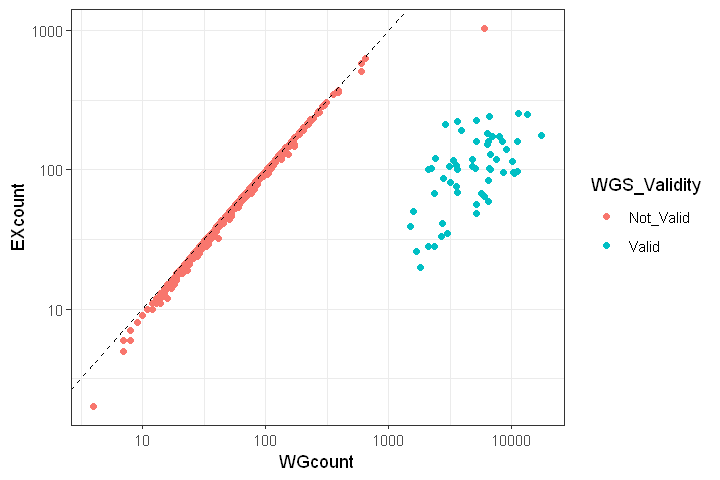

In [36]:
options(repr.plot.width=6, repr.plot.height=4)
pEXWG

<center>Figure 1 : total number of EXS mutations in function of the total number of WGS mutations. The WGS validity is highlighted for all available tumors.</center>

<a id='rpSP'></a>

<h4>Whole exome sequenced tumors characterization (<a href="#pSP">code</a>)</h4>

The similarity scores observed on Figure 2 show poor EXS tumors characterization when comparing with the WGS ones. Indeed the similarity score for a good characterization is assumed to be greater than 0.95. In this case we only observe hot spots around 0.55 and 0.75. Interestingly the proportion of EXS mutations found in WGS has no clear effect on the Similarity score. Indeed a Pearson correlation of 0.04 with a p-value of 0.77 is computed from Figure 2, showing no statistically significant relationship.

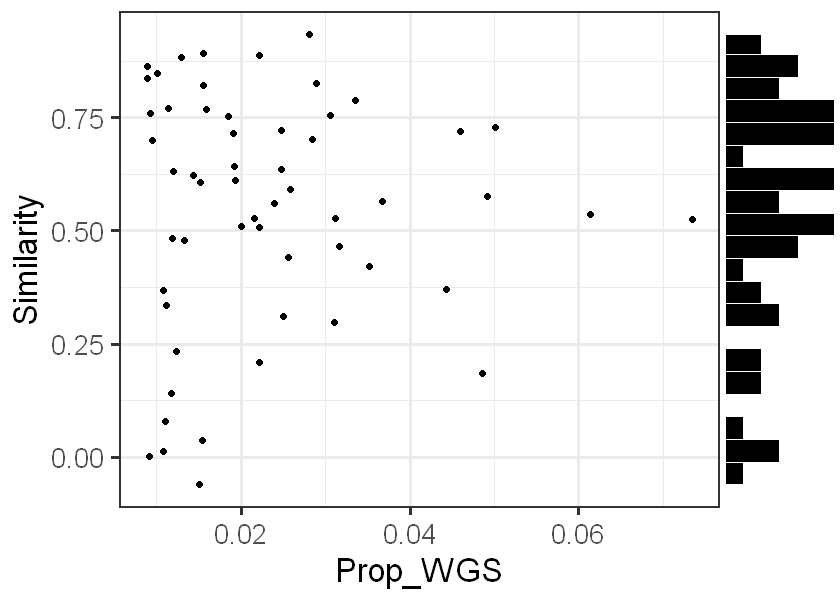

In [37]:
options(repr.plot.width=7, repr.plot.height=5)
ggExtra::ggMarginal(pSP, type = "histogram", binwidth = 0.05, margins = "y", colour = "#FFFFFF", fill = "#000000")

<center>Figure 2 : Similarity score of the EXS tumor with its WGS tumor in function of the EXS mutation proportion in its WGS tumor.</center>

<a id='rpBP'></a>

<h4>Similarity null distribution (<a href="#pBP">code</a>)</h4>

We can observe the Similarity scores distribution from 1000 bootstrapped tumors with the original WGS tumor with the number of mutations bootstrapped equalling the number of mutations available in their EXS. The red bar represents the Similarity score of the EXS tumor with the WGS tumor.<br>
The EXS reference (in red on Figure 3) is below, inside and above the interquartile range distribution for respectively 10 (30%), 19 (58%) and 4 (12%) tumors. Only one tumor shows median Similarity score above 0.95. And the majority of the tumors have less than 100 mutations available in EXS.

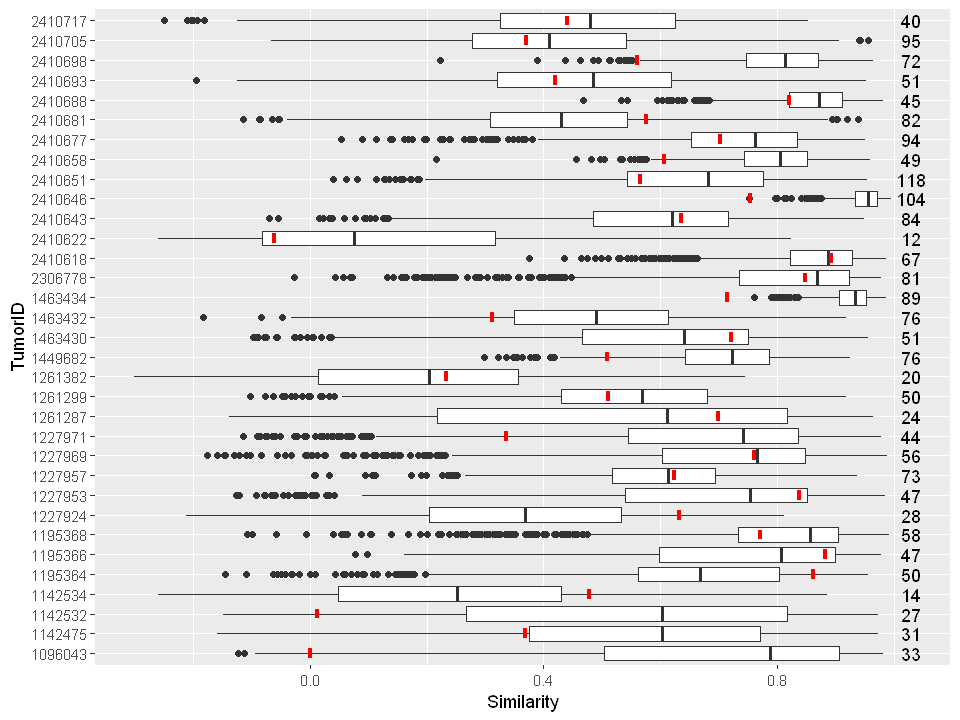

In [38]:
options(repr.plot.width=8, repr.plot.height=6)
pBP + coord_flip()

Figure 3 : Similarity scores distribution from 1000 bootstrapped tumors with the original WGS tumor with the number of mutations bootstrapped.

<a id='rpDH'></a>

<h4>Tumors clustering (<a href="#heatmap">code</a>)</h4>

The tumors are arbitrarily isolated into Cluster1, Cluster2, Cluster3 and Cluster4 containing respectively 25, 3, 4 and 1 tumors (see Figure 4). Cluster2, Cluster3 and Cluster4 show higher proportions of T[C>T]A, T[C>G]T and T[C>G]A mutations than in Cluster1. Cluster3 and Cluster4 show even higher proportions of T[C>T]A than Cluster1 and Cluster2. Finally Cluster3 tend to show higher proportions of T[C>G]T and T[C>G]A mutations than Cluster1, Cluster2 and Cluster4. Cluster1 and Cluster3 have therefore respectively the most flatten and scattered mutation class distributions.

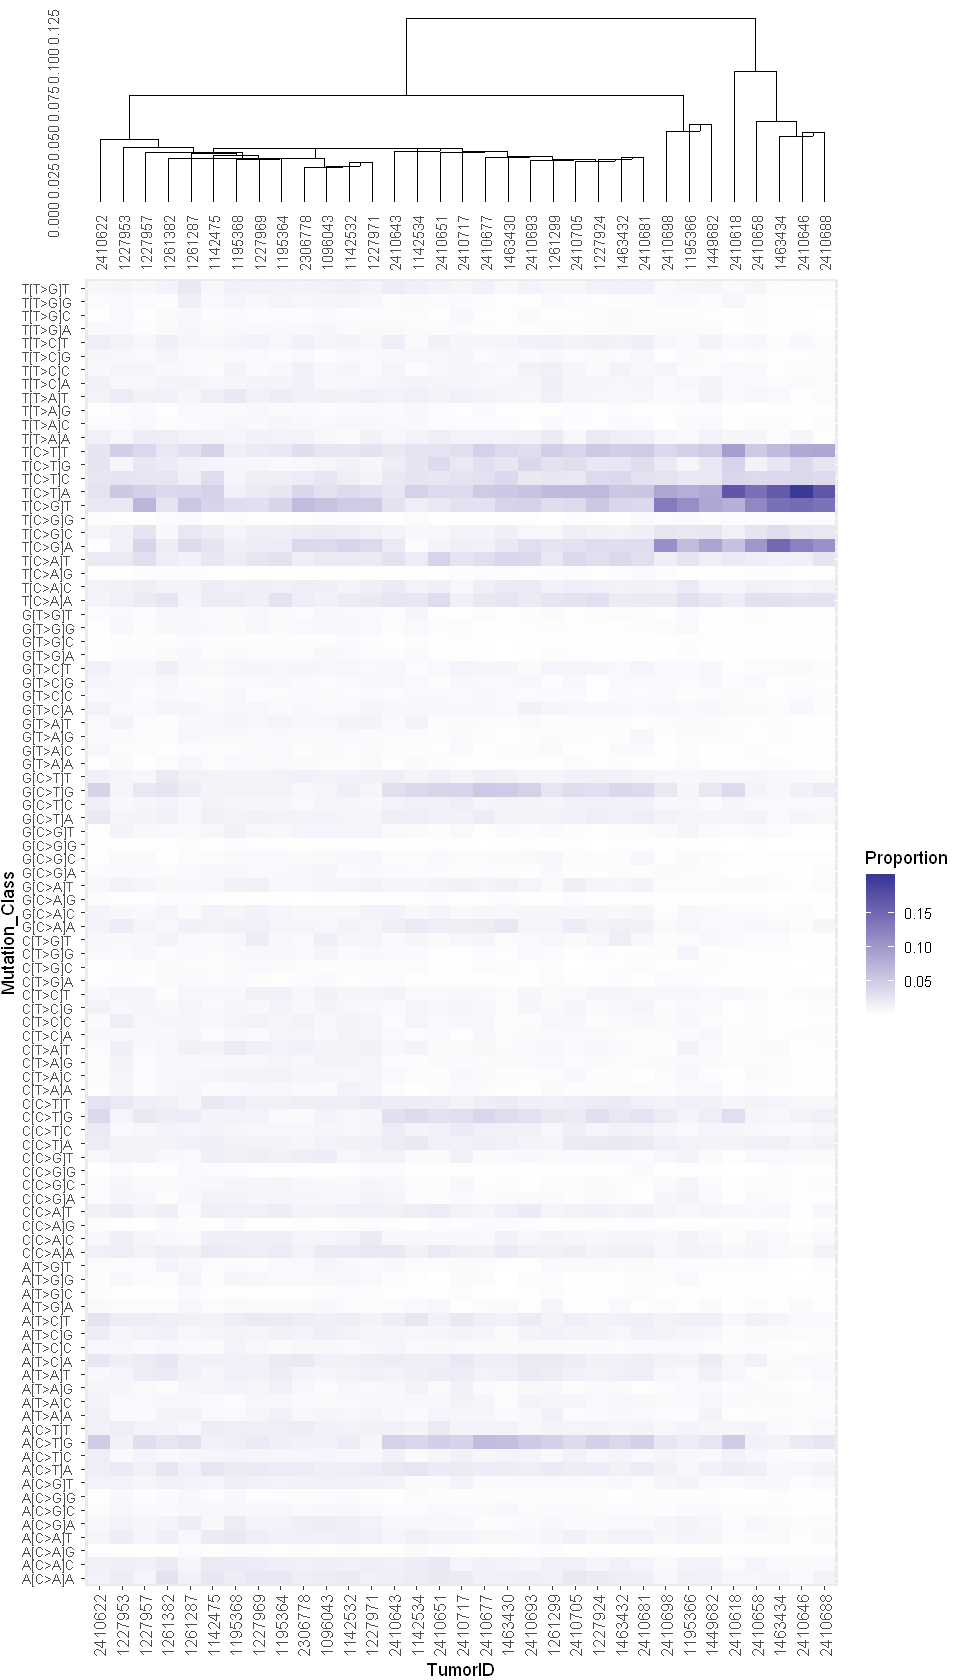

In [39]:
options(repr.plot.width=8, repr.plot.height=14)
pDH

<center>Figure 4 : centroid linkage hierarchical clustering of 33 tumors based on the Euclidian distances between their mutation class proportions.</center>

<a id='rpBC'></a>

<h4>Mutational signatures stability (<a href="#pBC">code</a>)</h4>

Cluster1 and Cluster3 tend to show respectively inferior and higher stability after comparison with all clusters (see Figure 5).

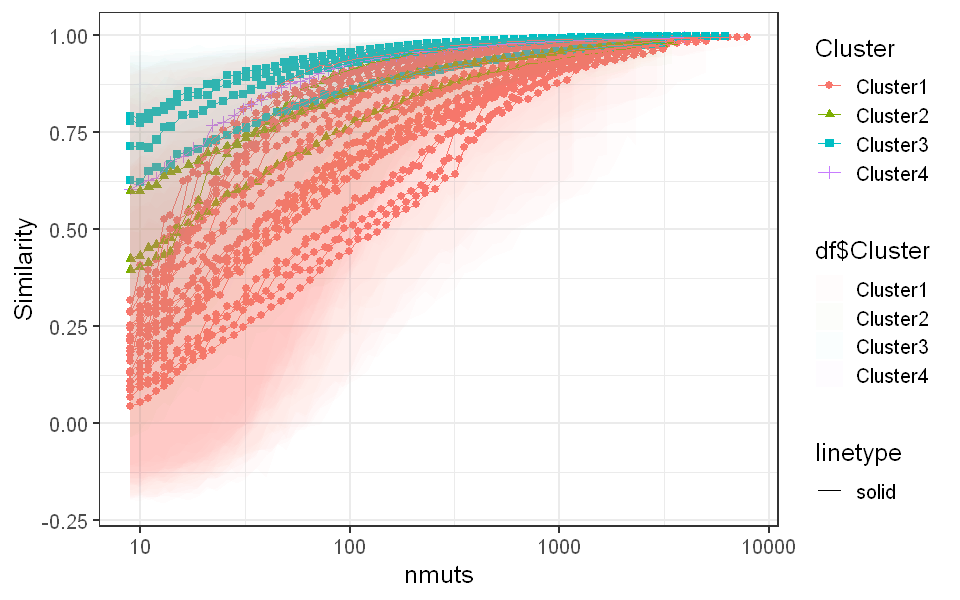

In [40]:
options(repr.plot.width=8, repr.plot.height=5)
pBC

Figure 5 : median Similarity score of 1000 bootstrapped tumors with the original WGS tumor in function of the number of mutations bootstrapped from the original WGS mutation class distribution.

<a id='DC'></a>

## Discussion and conclusion

<a href="#rpEXWG">Figure 1</a> can be explained by data manipulation errors or by the fact that many tumors from COSMIC are falsly described as WGS. <a href="#rpSP">Figure 2</a> shows that the EXS mutations are not enough to accurately describe the COSMIC signatures proportions found in WGS. And no clear correlation is observed between the Similarity score and the proportion of mutations available in WGS. It is therefore supposed that mutation class proportions observed in the whole exome are different from the ones observed in the whole genome. <a href="#rpBP">Figure 3</a> supports these mutation class differences supposition since the EXS reference is negatively biaised across all tumors.
Finally having more flatten mutation class distributions tend to be less probable when fewer number of mutations are available. It explains why the characterization of the tumors having less scattered mutation class distributions (see <a href="#rpDH">Figure 4</a>) is less stable under decreasing number of mutations (see <a href="#rpBC">Figure 5</a>). Tumors having more scattered mutation class distributions are therefore more stable in these conditions. But high drops of tumoral characterization performance are also observed for these tumors under 100 mutations sampled (see <a href="#rpBC">Figure 5</a>) which corresponds to EXS conditions.<br>
In conclusion this project highlights that the number of EXS mutations available is not enough to accurately describe the COSMIC signatures found in WGS. To resolve this issue an other set of strongly regularized signatures (<a href="https://www.biorxiv.org/content/10.1101/384834v1">source</a>) is used and slight increases of tumoral characterization are observed, but I believe that the loss of biological meaning does not worth it (data not shown).